In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
import pytorch_lightning as pl
from torchvision import models
import torch_pruning as tp
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import networkx as nx
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset

# Set MPS as the default device
torch.set_default_device("mps")

In [2]:
class AlexNetFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, num_classes=10):
        super(AlexNetFineTuner, self).__init__()
        self.save_hyperparameters()

        # Load pre-trained AlexNet
        self.model = models.alexnet(pretrained=False)
        self.model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Update the classifier layer

        # Initialize metrics dictionary
        self.metrics = {
            "pruning_percentage": [],
            "test_accuracy": [],
            "test_loss": [],
            "model_size": []
        }

    def forward(self, x):
        return self.model(x)

    def print_dependency_graph(self, DG):
        print("\nDependency Graph Details:")
        for module, node in DG.module2node.items():
            print(f"Module: {module}")
            for dep in node.dependencies:
                print(f"    * Target Module: {dep.target.module}")

    def visualize_dependency_graph(self, DG):
        """Visualize the dependency graph using networkx."""
        G = nx.DiGraph()
        for module, node in DG.module2node.items():
            for dep in node.dependencies:
                G.add_edge(str(module), str(dep.target.module))
        plt.figure(figsize=(12, 8))
        nx.draw(G, with_labels=True, node_size=1000, font_size=8, node_color="skyblue", edge_color="gray")
        plt.title("Dependency Graph")
        plt.show()

    def prune_model(self, pruning_percentage=0.2):
        # example_inputs = torch.randn(1, 3, 224, 224)  # Example input for dependency graph
        example_inputs = torch.randn(1, 3, 224, 224, dtype=torch.float32).to("mps")
        print("Example inputs device and dtype:------------------------", example_inputs.device, example_inputs.dtype)

        print(f"Model device-------------------: {next(self.model.parameters()).device}, dtype: {next(self.model.parameters()).dtype}")

        DG = tp.DependencyGraph().build_dependency(self.model, example_inputs)
        self.print_dependency_graph(DG)
        self.visualize_dependency_graph(DG)

        # Choose a layer to prune
        layer_to_prune = self.model.classifier[1]
        self.metrics["model_size"].append(sum(p.numel() for p in self.model.parameters() if p.requires_grad))
        self.metrics["pruning_percentage"].append(0 if not self.metrics["pruning_percentage"] else pruning_percentage * 100)

        # Prune layer
        num_features = layer_to_prune.out_features
        pruning_idxs = torch.arange(0, int(num_features * pruning_percentage)).tolist()
        group = DG.get_pruning_group(layer_to_prune, tp.prune_linear_out_channels, idxs=pruning_idxs)
        if DG.check_pruning_group(group):
            group.prune()

        # Update metrics after pruning
        self.metrics["model_size"].append(sum(p.numel() for p in self.model.parameters() if p.requires_grad))
        self.metrics["pruning_percentage"].append(pruning_percentage * 100)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS

        print("Images device and dtype:---------------------", images.device, images.dtype)
        print("Labels device and dtype:", labels.device, labels.dtype)

        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS
        outputs = self(images)
        val_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        val_acc = (preds == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS
        outputs = self(images)
        test_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        test_acc = (preds == labels).float().mean()
        self.metrics["test_accuracy"].append(test_acc.item())
        self.metrics["test_loss"].append(test_loss.item())
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", test_acc, prog_bar=True)
        return test_loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}



In [3]:
def plot_metrics(metrics):
    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_accuracy"], marker='o', label="Accuracy")
    plt.title("Test Accuracy vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_loss"], marker='o', color="orange", label="Loss")
    plt.title("Test Loss vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["model_size"], marker='o', color="green", label="Model Size")
    plt.title("Model Size vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Number of Parameters")
    plt.grid(True)
    plt.legend()
    plt.show()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p-mangal (p-mangal-university-of-amsterdam). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model device-------------------: mps:0, dtype: torch.float32
Applying 0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32

Dependency Graph Details:
Module: Linear(in_features=4096, out_features=10, bias=True)
    * Target Module: _ElementWiseOp_0(ReluBackward0)
Module: _ElementWiseOp_0(ReluBackward0)
    * Target Module: Linear(in_features=4096, out_features=4096, bias=True)
    * Target Module: Linear(in_features=4096, out_features=10, bias=True)
Module: Linear(in_features=4096, out_features=4096, bias=True)
    * Target Module: _ElementWiseOp_1(ReluBackward0)
    * Target Module: _ElementWiseOp_0(ReluBackward0)
Module: _ElementWiseOp_1(ReluBackward0)
    * Target Module: Linear(in_features=9216, out_features=4096, bias=True)
    * Target Module: Linear(in_features=4096, out_features=4096, bias=True)
Module: Linear(in_features=9216, out_features=4096, bias=True)
    * Target Module: _Reshape_2()
    * Target Module: _ElementWiseOp_1(ReluBackward

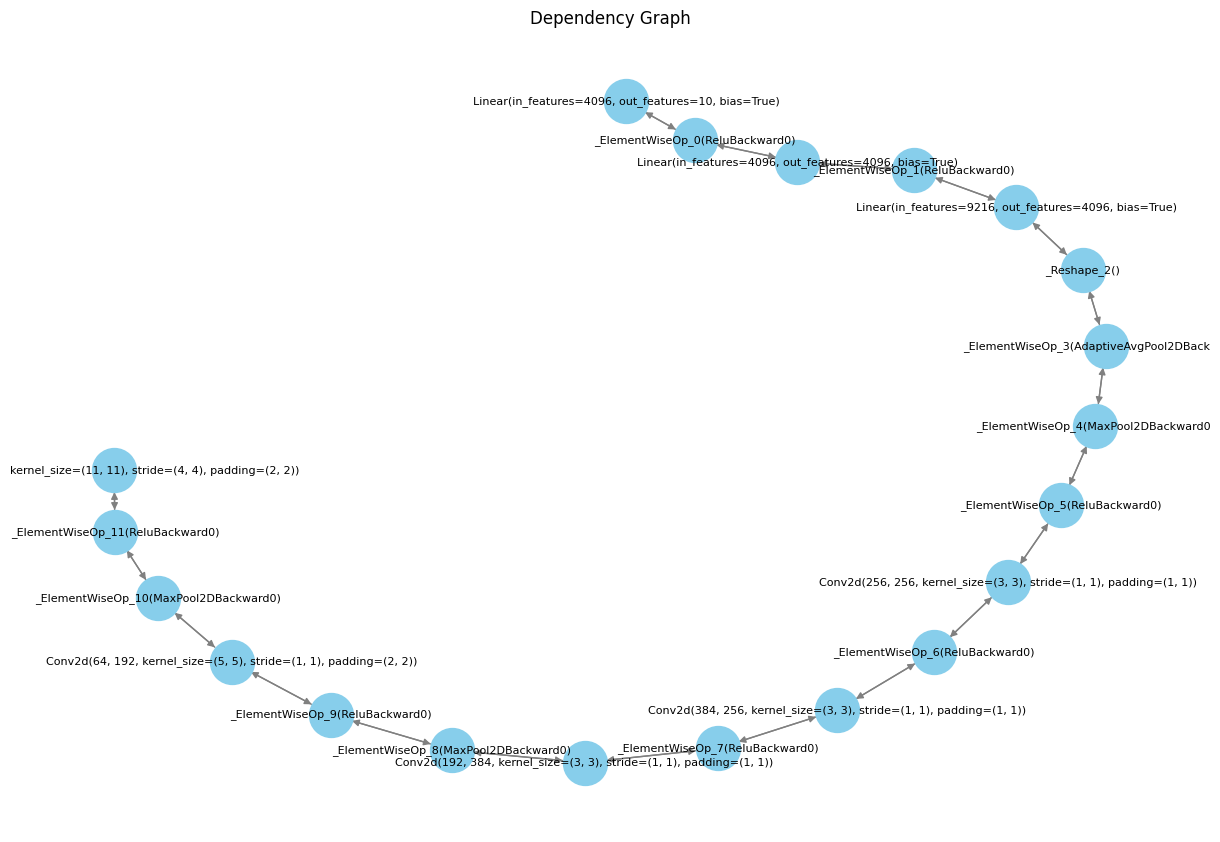

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8700000047683716     │
│         test_loss         │     0.34062659740448      │
└───────────────────────────┴───────────────────────────┘

Applying 10.0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [4]:
def main():
    wandb.init(project='alexnet_depGraph', name='AlexNet_Run')
    wandb_logger = WandbLogger(log_model=False)

    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = Subset(CIFAR10(root='./data', train=True, download=True, transform=transform), range(500))
    test_dataset = Subset(CIFAR10(root='./data', train=False, download=True, transform=transform), range(100))
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    checkpoint_path = "../checkpointsAlex/best-checkpoint.ckpt"
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path)
    model = model.to(torch.float32)
    for param in model.parameters():
        param.data = param.data.to(torch.float32).to("mps")
        if param.grad is not None:
            param.grad = param.grad.to(torch.float32).to("mps")

    print(f"Model device-------------------: {next(model.parameters()).device}, dtype: {next(model.parameters()).dtype}")

    pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    for pruning_percentage in pruning_percentages:
        print(f"Applying {pruning_percentage * 100}% pruning...")
        model.prune_model(pruning_percentage=pruning_percentage)
        trainer = pl.Trainer(logger=wandb_logger)
        trainer.test(model, dataloaders=test_dataloader)

    plot_metrics(model.metrics)
    wandb.finish()


if __name__ == "__main__":
    main()